## PySMuRF Setup

In [1]:
import pysmurf.client
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import epics
import os

%matplotlib inline

Next we'll define the EPICS server prefix and experiment configuration file

In [2]:
epics_prefix = "smurf_server_s2"
config_file  = "/usr/local/src/pysmurf/cfg_files/mit/experiment_mit.cfg"
S = pysmurf.client.SmurfControl(epics_root=epics_prefix, cfg_file=config_file, setup=False, make_logfile=False)

Now can talk to system using S object.

In [4]:
S.all_off()

[ 2021-10-16 07:36:10 ]  Turning off tones
[ 2021-10-16 07:36:15 ]  Turning off flux ramp
[ 2021-10-16 07:36:15 ]  Turning off all TES biases


Note the PSD frequency is plotted +/- 0MHz. Each digitizer has complex data at 614.4MHz corresponding to +/- 307.2MHz BW at baseband.  For band=3 this is 0MHz + 5750MHz = 4250MHz.


### Transfer function of the system

Next we can look at a transfer function estimate.  This will play a known random number sequence through the DAC and record the ADC response.  We'll use cross correlation to generate a transfer function estimate:

[ 2021-10-16 07:36:27 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 4096
[ 2021-10-16 07:36:28 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2021-10-16 07:36:28 ]  ADC0 max count: 5025
[ 2021-10-16 07:36:28 ]  ADC0 min count: -4817
[ 2021-10-16 07:36:28 ]  ADC0 not saturated
[ 2021-10-16 07:36:28 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2021-10-16 07:36:28 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2021-10-16 07:36:28 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2021-10-16 07:36:28 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2021-10-16 07:36:28 ]  UC (DAC) att: 0
[ 2021-10-16 07:36:28 ]  DC (ADC) att: 0


/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1812: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


[ 2021-10-16 07:36:29 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 4096
[ 2021-10-16 07:36:29 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2021-10-16 07:36:29 ]  ADC0 max count: 4566
[ 2021-10-16 07:36:29 ]  ADC0 min count: -4697
[ 2021-10-16 07:36:29 ]  ADC0 not saturated
[ 2021-10-16 07:36:29 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2021-10-16 07:36:29 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2021-10-16 07:36:29 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2021-10-16 07:36:29 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2021-10-16 07:36:29 ]  UC (DAC) att: 0
[ 2021-10-16 07:36:29 ]  DC (ADC) att: 0
[ 2021-10-16 07:36:29 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 4096
[ 2021-10-16 07:36:29 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTo

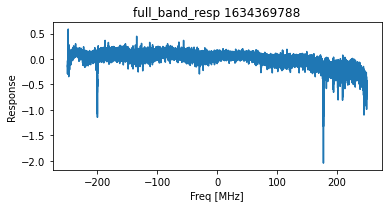

In [5]:
S.set_att_uc(0,0) # Make sure upconvert attenuators which set the SMuRF output power are zero
f,resp=S.full_band_resp(band=0, make_plot=True, show_plot=True, n_scan=10)

The response is measured about 0MHz baseband which for band=0 is 4250 MHz RF.  We expect two resonators in band 0 ; one at 4.0495 GHz and one at 4.4275 GHz, or at -200.5 MHz and 177.5 MHz.

(-202500000.0, -197500000.0)

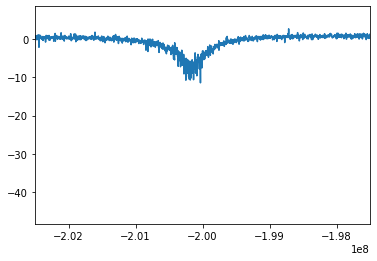

In [6]:
plt.plot(f,10.*np.log10(np.abs(resp)))
plt.xlim(-202.5e6,-197.5e6)

So that's what it looks like.

### Identifying resonator locations

Each SMuRF band is processed by an oversampled x2 polyphase filter bank.  The filter bank breaks the +/-307.2MHz band into subbands.  Subband 0...127 correspond to -307.2MHz...307.2MHz.  Only subbands +/-250MHz are processed.  We can do a tone sweep to see the subband structure and identify resonator locations within each subband.  The plot shows the interleaved subbands in different colors.

[ 2021-10-16 07:36:57 ]  Sweeping across frequencies 4000.0MHz to 4500.0MHz
[ 2021-10-16 07:36:57 ]  Working on band 0
[ 2021-10-16 07:37:34 ]  serial find freq complete ; etaScanInProgress = 0


/usr/local/src/pysmurf/python/pysmurf/client/tune/smurf_tune.py:896: RuntimeWarning: invalid value encountered in double_scalars
  if 1-amp[idx]/med_amp[idx] > amp_cut:


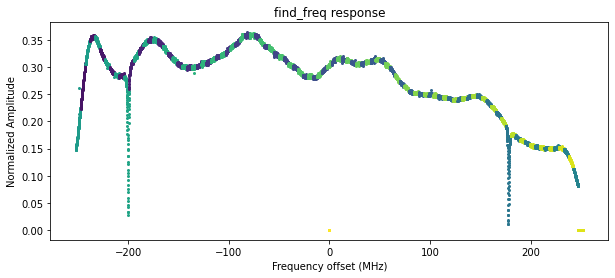

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]))

In [7]:
S.find_freq(band=0, tone_power=12, make_plot=True, show_plot=True)

In [25]:
# Look for the latest *_find_freq.png image in this directory;
S.plot_dir

'/data/smurf_data/20211015/1634337061/plots'

This function will also make a plot showing whether or not it found all resonator like features in the measured transmission.  Looks like we find them with the default SMuRF frequency sweeping algorithm:
![band 0 resonators identified](1634337792_b0_find_freq.png)

### Fine resolution resonator scans
Next we run a fine resonator scan and set the nominal tone frequency, drive power and rotation.  Feedback operates on the RF demodulated Q and performs feedback to drive Q to 0.

In [9]:
S.setup_notches(band=0, tone_power=12, sweep_width=1, delta_freq=0.1, df_sweep=0.01, new_master_assignment=True)
# Plots will be saved in S.plot_dir
S.plot_tune_summary(band=0, eta_scan=True)
print("These plots are saved at: " + S.plot_dir)
# run a gradient descent to find resonator dip
#S.run_serial_gradient_descent(0) 
# run eta scan to normalize resonator gain (delta Q -> delta frequency) and apply rotation such that Q is nominally 0
#S.run_serial_eta_scan(0) 

[ 2021-10-16 07:38:25 ]  freq 4049.8400 - 1 of 2
[ 2021-10-16 07:38:25 ]  freq 4427.7600 - 2 of 2
[ 2021-10-16 07:38:26 ]  Writing new channel assignment to /data/smurf_data/tune/1634369906_channel_assignment_b0.txt
[ 2021-10-16 07:38:26 ]  Old master assignment file: /data/smurf_data/tune/1634342629_channel_assignment_b0.txt
[ 2021-10-16 07:38:26 ]  New master assignment file: /data/smurf_data/tune/1634369906_channel_assignment_b0.txt
[ 2021-10-16 07:38:27 ]  serial find freq complete ; etaScanInProgress = 0
[ 2021-10-16 07:38:28 ]  Assigning channels
[ 2021-10-16 07:38:28 ]  Writing new channel assignment to /data/smurf_data/tune/1634369908_channel_assignment_b0.txt
[ 2021-10-16 07:38:28 ]  Old master assignment file: /data/smurf_data/tune/1634369906_channel_assignment_b0.txt
[ 2021-10-16 07:38:28 ]  New master assignment file: /data/smurf_data/tune/1634369908_channel_assignment_b0.txt
[ 2021-10-16 07:38:28 ]  Saving to : /data/smurf_data/tune/1634369908_tune.npy
[ 2021-10-16 07:38:2

Here's our eta scan for band 0, the complex response is multiplied by the complex value eta to apply the scaling/rotation for feedback.

![res000](1634338258_eta_b0_res000.png)
![res001](1634338258_eta_b0_res001.png)



### Looking at on resonance noise
Now we can examine resonator noise.  The eta scan sets up with feedback enabled so we'll turn it off and look at open loop frequency error (quadrature voltage).

First we'll get of list of resonators that are on and tracking:

In [10]:
S.which_on(band=0)

array([53, 82])

In [15]:
band=0
channel=53
nsamp=2**20

S.set_feedback_enable(band=band, val=0)
S.set_feedback_enable_channel(band=band,channel=channel,val=0)

# Quadrature noise
fq, dfq, syncq = S.take_debug_data(band=band, channel=channel, nsamp=nsamp, IQstream=0, single_channel_readout=2)
tq = np.arange(len(dfq))/(1.e6*S.get_channel_frequency_mhz(band))

# Rotate into the other quadrature.
qetaPhaseDegree=S.get_eta_phase_degree_channel(band=band,channel=channel)
def etaPhaseModDegree(etaPhase):
    return (etaPhase+180)%360-180
# Rotating by 90 to get inphase 
S.set_eta_phase_degree_channel(band=band,channel=channel,val=etaPhaseModDegree(qetaPhaseDegree+90))

# Quadrature noise
fi, dfi, synci = S.take_debug_data(band=band, channel=channel, nsamp=nsamp, IQstream=0, single_channel_readout=2)
ti = np.arange(len(dfi))/(1.e6*S.get_channel_frequency_mhz(band))

[ 2021-10-16 07:40:58 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:readoutChannelSelect 53
[ 2021-10-16 07:40:58 ]  Writing to file : /data/smurf_data/20211016/1634369755/outputs/1634370059.dat
[ 2021-10-16 07:40:58 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 1048576
[ 2021-10-16 07:40:58 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2021-10-16 07:40:58 ]  Data acquisition in progress...
[ 2021-10-16 07:40:58 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2021-10-16 07:41:01 ]  Done taking data
[ 2021-10-16 07:41:01 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:readoutChannelSelect 53
[ 2021-10-16 07:41:01 ]  Writing to file : /data/smurf_data/20211016/1634369755/outputs/1634370061.dat
[ 2021-10-16 07:41:01 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 1048576
[ 2021-10-16 07:41:01 ]  caput smurf_serv

In [16]:
meaniq=np.mean(np.mean(dfi)**2 + np.mean(dfq)**2)
print(meaniq)

ffi,pxxi=signal.welch(dfi, nperseg=len(fi)/8., fs=1.0E6*S.get_channel_frequency_mhz(band))
ffq,pxxq=signal.welch(dfq, nperseg=len(fq)/8., fs=1.0E6*S.get_channel_frequency_mhz(band))

0.007015290869855677


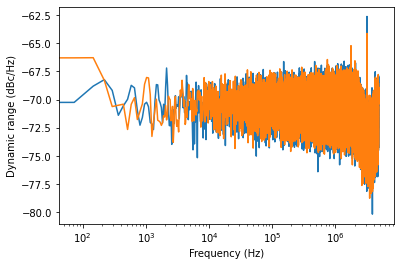

In [17]:
plt.semilogx(ffi,10.*np.log10(pxxi/meaniq))
plt.semilogx(ffq,10.*np.log10(pxxq/meaniq))

plt.xlabel('Frequency (Hz)')
plt.ylabel('Dynamic range (dBc/Hz)')

plt.show()

Alternate method ; rfIQ mode.

In [18]:
i2,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp)

[ 2021-10-16 07:44:20 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:readoutChannelSelect 53
[ 2021-10-16 07:44:20 ]  Writing to file : /data/smurf_data/20211016/1634369755/outputs/1634370261.dat
[ 2021-10-16 07:44:20 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 1048576
[ 2021-10-16 07:44:20 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2021-10-16 07:44:20 ]  Data acquisition in progress...
[ 2021-10-16 07:44:20 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2021-10-16 07:44:23 ]  Done taking data


This math might be wrong.

In [19]:
eta_phase = S.get_eta_phase_degree_channel(band, channel)
eta_phase_rad = np.deg2rad(eta_phase)
I = np.cos(eta_phase_rad) * i2 - np.sin(eta_phase_rad) * q
Q = np.sin(eta_phase_rad) * i2 + np.cos(eta_phase_rad) * q

ffi,pxxi = signal.welch(I,fs=1.e6*S.get_channel_frequency_mhz(band),nperseg=len(i2)/8)
ffq,pxxq = signal.welch(Q,fs=1.e6*S.get_channel_frequency_mhz(band),nperseg=len(i2)/8)

Now plot.

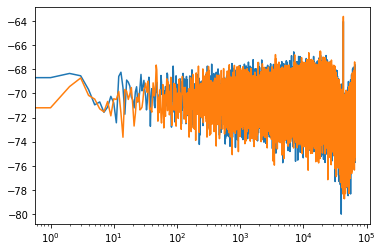

In [23]:
magfac = np.mean(q)**2 + np.mean(i2)**2
pxxi_dbc = 10. * np.log10(pxxi / magfac)
pxxq_dbc = 10. * np.log10(pxxq / magfac)

plt.semilogx(pxxi_dbc)
plt.semilogx(pxxq_dbc)

(1000.0, 10000.0)

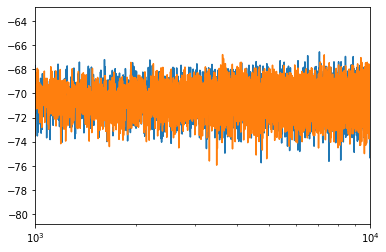

In [24]:
plt.semilogx(pxxi_dbc)
plt.semilogx(pxxq_dbc)

plt.xlim(1e3,1e4)